### Google Analytics 4 and BigQuery with Pandas
#### [GA4 Public Dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ga4_obfuscated_sample_ecommerce&t=events_20210131&page=table)


In [71]:
from google.cloud import bigquery
from google.colab import auth, drive
from google.oauth2 import service_account
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# authenticate and mount Google drive
auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path to secrets file
path = Path() / 'drive/My Drive/Colab Notebooks/secrets'
secrets_file = path / 'bigquery-project-33-33-33b336f4857f.json'

# Use a service account for authentication onto GCP
credentials = service_account.Credentials.from_service_account_file(secrets_file)

# The project id to which the service account has access
project_id = 'bigquery-project-33-33'

# Establish a connection to the client
client = bigquery.Client(credentials=credentials, project=project_id)

In [49]:
# Perform a query which extracts event information for one date (2021-01-31)
query = client.query(
"""SELECT
      event_date,
      event_timestamp,
      event_name,
      event_params.value.string_value AS page_url,
      device.*,
      device.web_info.*,
      geo.*
   FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20201101`,
   UNNEST(event_params) AS event_params -- UNNEST allows us to extract the nested records
   WHERE event_params.key = 'page_location'
""")

In [50]:
# Convert output into a pandas dataframe
df = query.to_dataframe()
df.head()

,event_date,event_timestamp,event_name,page_url,category,mobile_brand_name,mobile_model_name,mobile_marketing_name,mobile_os_hardware_model,operating_system,...,time_zone_offset_seconds,web_info,browser,browser_version,continent,sub_continent,country,region,city,metro
0,20201101,1604192073036492,page_view,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
1,20201101,1604192073036492,first_visit,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
2,20201101,1604192082302672,user_engagement,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
3,20201101,1604192073036492,session_start,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
4,20201101,1604202750089608,user_engagement,https://shop.googlemerchandisestore.com/,mobile,Samsung,<Other>,<Other>,<NA>,Android,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Americas,Northern America,United States,Washington,(not set),(not set)


### Using Functions
We can use functions in python for usability, increased readability and repeatability. Let's take our SQL query and turn it into a function so we can just write our query as usual. I'd also like to know the amount we are processing for each query so we have an idea of the cost.

In [51]:
def sql(client, query_string):
    query = client.query(query_string)
    df = query.to_dataframe()
    print(query.total_bytes_billed)
    return df

In [52]:
sql(client, """SELECT event_date FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210131` LIMIT 10""")


10485760


,event_date
0,20210131
1,20210131
2,20210131
3,20210131
4,20210131
5,20210131
6,20210131
7,20210131
8,20210131
9,20210131


#### Another advantage to Python is we can use variables within our searches
Instead of hardcoding the dataset name, we can replace it with a variable to improve readability. We can also make our function reusable - in this case the date at the end corresponds to one shard (one date) in the entire dataset, we can use a variable for that too. Let's use an f-string below

In [53]:
# Let's define our variables here
project = "bigquery-public-data"
dataset = "ga4_obfuscated_sample_ecommerce"
table = 'events'
date = '20201101'

# Begin the string with an f while wrapping any variables in braces: {}
query_string = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  event_params.value.string_value AS page_url,
  device.*
FROM
  `{project}.{dataset}.{table}_{date}`,
  UNNEST(event_params) AS event_params --UNNEST allows us to extract the nested records
WHERE
  event_params.key = 'page_location'
"""

# Print the output so we can see our formatted query
print(query_string)



SELECT
  event_date,
  event_timestamp,
  event_name,
  event_params.value.string_value AS page_url,
  device.*
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20201101`,
  UNNEST(event_params) AS event_params --UNNEST allows us to extract the nested records
WHERE
  event_params.key = 'page_location'



#### Repeating query for multiple dates
Now let's bring this altogether, we can run our function for multiple dates using a for loop and append the results to form one large dataset. Let's run our query again for the rest of the week and append the data to our intial dataframe. (2020-11-01)

In [54]:
# Let's use the datetime library for reliability
from datetime import datetime, timedelta

# Let's start from the next day in the dataset
start_date = datetime(2020,11,2) #(y,m,d,h,m)

# Our date_end is start_date + 5 days
end_date = start_date + timedelta(days=0)

# This should give us the rest of the week (2020-11-01 + 6 days)
print(start_date, end_date)

2020-11-02 00:00:00 2020-11-02 00:00:00


In [55]:
# Use a pandas function to create the range of days to iterate through
dates = pd.date_range(start_date, end_date)


# Let's define our variables here
project = "bigquery-public-data"
dataset = "ga4_obfuscated_sample_ecommerce"
table = 'events'
data = {}

# Run the query for each date, appending to our dataframe "df"
for date in dates:

    # We need to reformat so it matches the table naming convention: 20201101
    date = date.strftime('%Y%m%d')

    query_string = f"""
    SELECT
      event_date,
      event_timestamp,
      event_name,
      event_params.value.string_value AS page_url,
      device.*
    FROM
      `{project}.{dataset}.{table}_{date}`,
      UNNEST(event_params) AS event_params --UNNEST allows us to extract the nested records
    WHERE
      event_params.key = 'page_location'
    """
    data = sql(client, query_string)

    # concatenates our current dataframe with the just-retrieved data, axis=0 means appends data column-wise, instead of row-wise
    df = pd.concat([df, data], axis=0)

# Reset the index as otherwise we have repeated row indexes
df.reset_index(inplace=True, drop=True)
df.head()

19922944


,event_date,event_timestamp,event_name,page_url,category,mobile_brand_name,mobile_model_name,mobile_marketing_name,mobile_os_hardware_model,operating_system,...,time_zone_offset_seconds,web_info,browser,browser_version,continent,sub_continent,country,region,city,metro
0,20201101,1604192073036492,page_view,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
1,20201101,1604192073036492,first_visit,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
2,20201101,1604192082302672,user_engagement,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
3,20201101,1604192073036492,session_start,https://shop.googlemerchandisestore.com/Google...,desktop,Google,Chrome,<Other>,<NA>,Web,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Asia,Southern Asia,India,Delhi,Delhi,(not set)
4,20201101,1604202750089608,user_engagement,https://shop.googlemerchandisestore.com/,mobile,Samsung,<Other>,<Other>,<NA>,Android,...,<NA>,"{'browser': 'Chrome', 'browser_version': '86.0'}",Chrome,86.0,Americas,Northern America,United States,Washington,(not set),(not set)


## Quick Analytics Examples
Let's look at some examples of how we can use pandas for a quick overview of our dataset, conducting some basic analysis, or managing categorical values

#### Quick data insights

In [56]:
# Quick insight into the number of rows, columns, missing values (nulls) and data types
# Strings are objects, dates should be converted to datetime (we'll look at this later)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79660 entries, 0 to 79659
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   event_date                79660 non-null  object
 1   event_timestamp           79660 non-null  Int64 
 2   event_name                79660 non-null  object
 3   page_url                  79660 non-null  object
 4   category                  79660 non-null  object
 5   mobile_brand_name         79660 non-null  object
 6   mobile_model_name         79660 non-null  object
 7   mobile_marketing_name     79660 non-null  object
 8   mobile_os_hardware_model  0 non-null      Int64 
 9   operating_system          79660 non-null  object
 10  operating_system_version  79660 non-null  object
 11  vendor_id                 0 non-null      Int64 
 12  advertising_id            0 non-null      Int64 
 13  language                  44787 non-null  object
 14  is_limited_ad_tracking

In [57]:
# Overview of numerical data types with the describe() method
# Notice how the timestamp is treated as an integer and not a date!
df.describe()

,event_timestamp,mobile_os_hardware_model,vendor_id,advertising_id,time_zone_offset_seconds
count,79660.0,0.0,0.0,0.0,0.0
mean,-16691016522020.279297,<NA>,<NA>,<NA>,<NA>
std,50499526119.275566,<NA>,<NA>,<NA>,<NA>
min,1604188804579566.0,<NA>,<NA>,<NA>,<NA>
25%,1604244888243252.5,<NA>,<NA>,<NA>,<NA>
50%,1604296566726822.0,<NA>,<NA>,<NA>,<NA>
75%,1604333221633463.75,<NA>,<NA>,<NA>,<NA>
max,1604361598589454.0,<NA>,<NA>,<NA>,<NA>


#### Analysis of categorical variables

In [58]:
# The value_counts() method is a quick way of counting occurences for categorical variables
df.event_name.value_counts()

page_view              24731
user_engagement        22086
scroll                  8481
view_item               8315
session_start           6276
first_visit             4431
view_promotion          3769
view_search_results      389
begin_checkout           346
add_shipping_info        346
add_payment_info         211
select_promotion         160
purchase                  63
click                     40
view_item_list            12
add_to_cart                4
Name: event_name, dtype: int64

#### Plotting

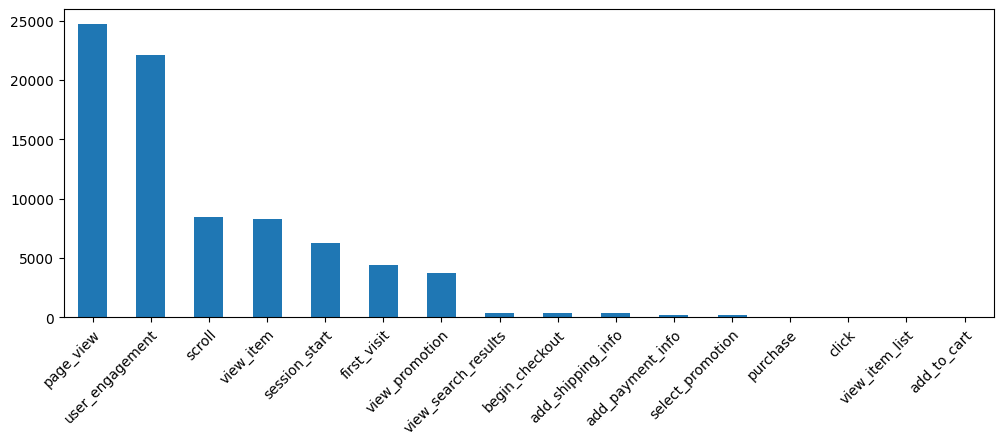

In [66]:
# We can plot the output of the value_counts() method
ax = df.event_name.value_counts().plot(kind='bar', figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor');

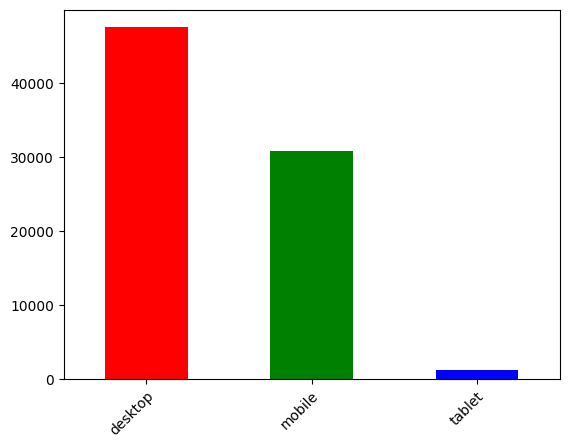

In [68]:
ax = df.category.value_counts().plot(kind='bar', color=['r','g','b'])
plt.setp(ax.get_xticklabels(), ha='right', rotation=45, rotation_mode='anchor');

#### We can use seaborn for more advanced plotting

In [16]:
#%pip install seaborn

In [69]:
# Let's look at the number of events for each device type using value_counts() and store it
events_by_device = df.category.value_counts()
events_by_device

desktop    47564
mobile     30869
tablet      1227
Name: category, dtype: int64

<ipython-input-70-25e48447dd04>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.event_timestamp);


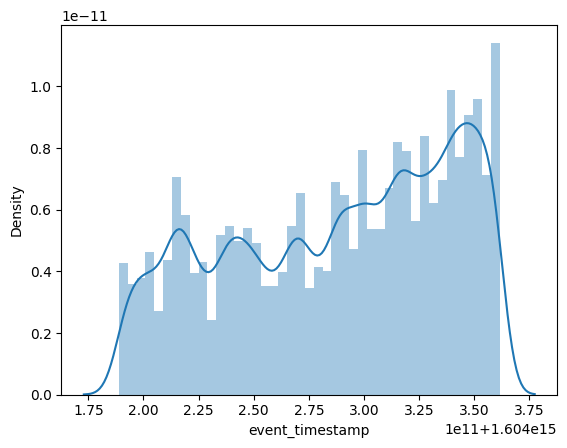

In [70]:
# import the seaborn library and give it the alias: sns
sns.displot(df.event_timestamp);